In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.dataset_custom import *
from models.ae import *
import torch
import random
from config import *

import numpy as np

In [2]:
model_list = os.listdir(model_results)
os.listdir(model_results)

['ae_4feat.pth',
 'ae_4_ft_4s.pth',
 'vae.pth',
 'ae_1ft.pth',
 'ae_4_ft_4s_sc.pth',
 'ae_1_ft.pth']

In [3]:
model_num = -2
print(model_list[model_num])

ae_4_ft_4s_sc.pth


In [4]:
checkpoint  = torch.load(model_results + '/' + model_list[model_num])
params_conf = checkpoint['param_conf']

In [5]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']

In [6]:
target = None

if target != None:
    no_features = len(cols) - len(target)
else:
    no_features = len(cols)
    target = cols

if scaled:
    train_iter = torch.load('../dataloader/train_dataloader_{}_ft.pth'.\
                            format(n_features))
    test_iter = torch.load('../dataloader/test_dataloader_{}_ft.pth'.\
                            format(n_features))
else:
    train_iter = torch.load('../dataloader/train_dataloader_{}_ft_not_scaled.pth'.\
                            format(n_features))
    test_iter = torch.load('../dataloader/test_dataloader_{}_ft_not_scaled.pth'.\
                            format(n_features))

In [7]:
params_conf.keys()

dict_keys(['architecture', 'columns', 'model_path', 'train_val_split', 'columns_subset', 'dataset_subset', 'batch_size', 'sequence_length', 'out_window', 'epochs', 'lr', 'n_layers', 'embedding_size', 'embedding_dim', 'latent_dim', 'N_binomial', 'target', 'predict', 'scaled', 'sampling_rate', 'data_path', 'dataset', 'model_name', 'n_features', 'output_size'])

In [13]:
model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(4, 128, batch_first=True)
    (LSTM1): LSTM(128, 64, batch_first=True)
    (enc): Linear(in_features=64, out_features=5, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(5, 64, batch_first=True)
    (LSTM1): LSTM(64, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=4, bias=True)
  )
)

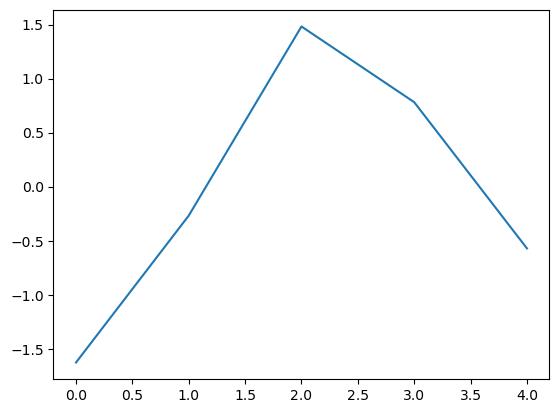

In [15]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))

feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

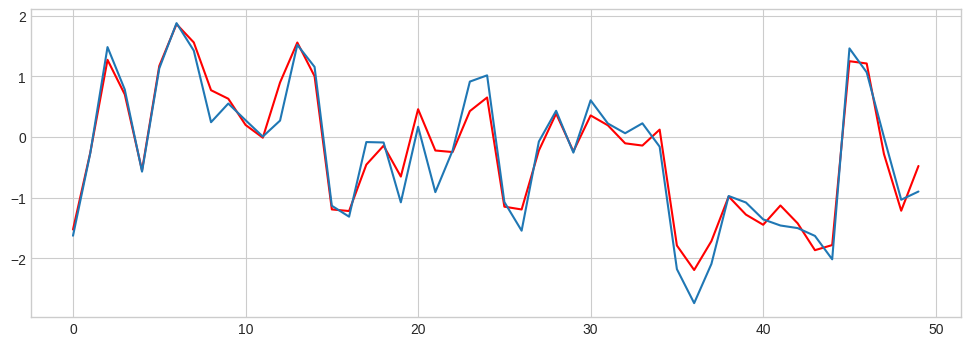

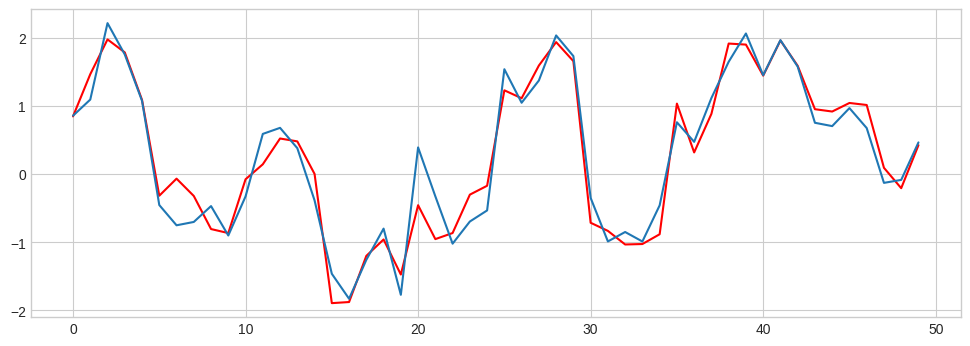

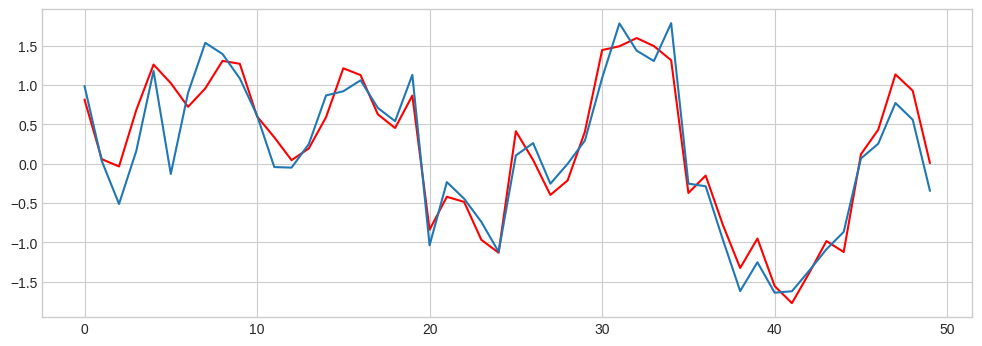

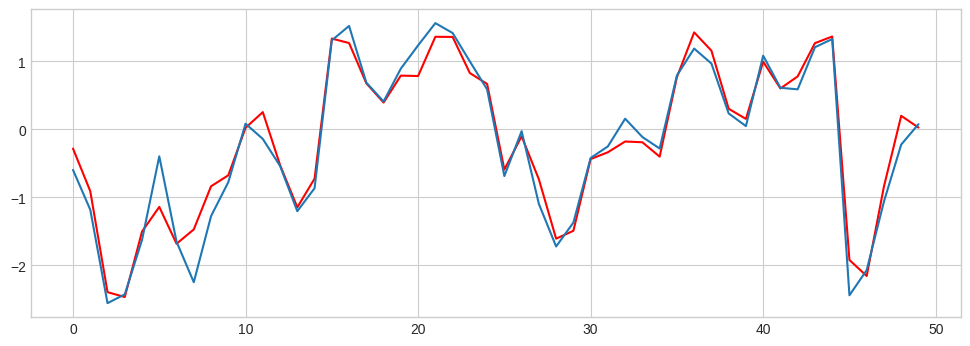

In [16]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

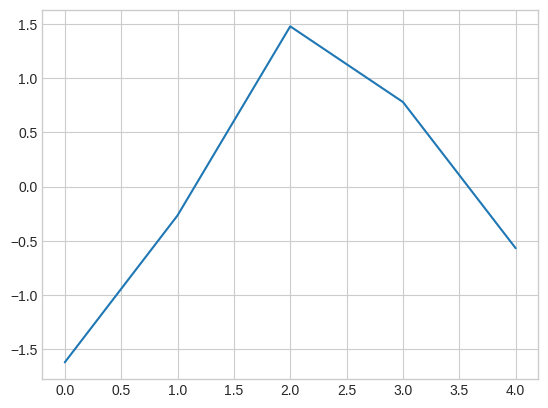

In [17]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

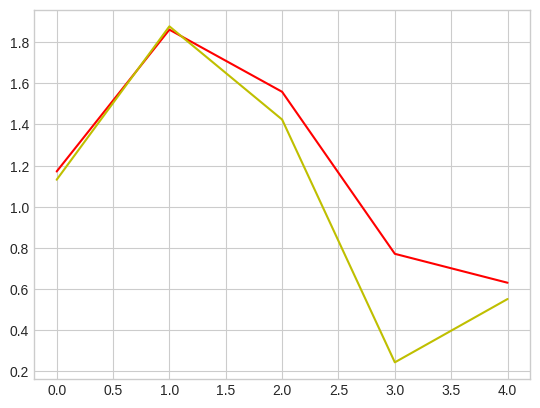

In [18]:
plt.plot(yo[1,:,feat].to("cpu").detach().numpy(), 'r')
plt.plot(y[1,:,feat].to("cpu").detach().numpy(), 'y')

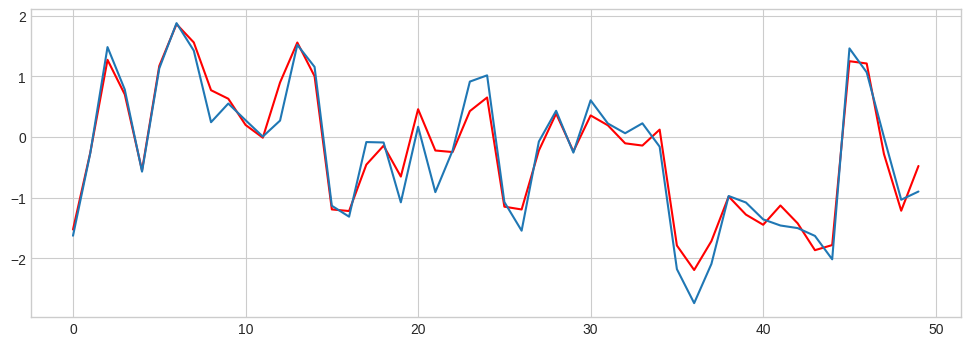

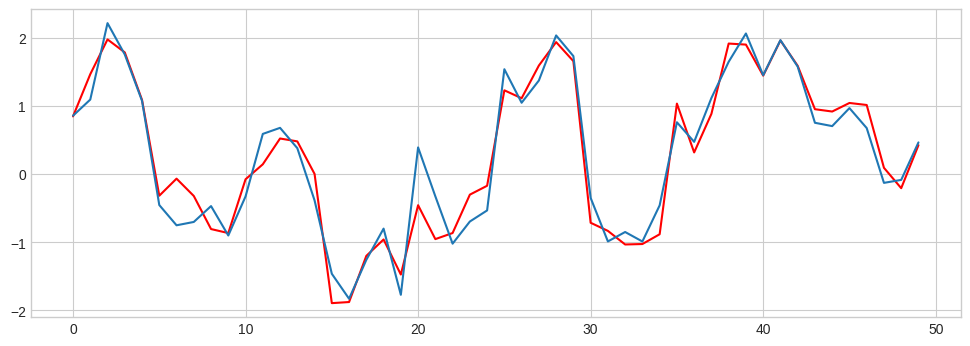

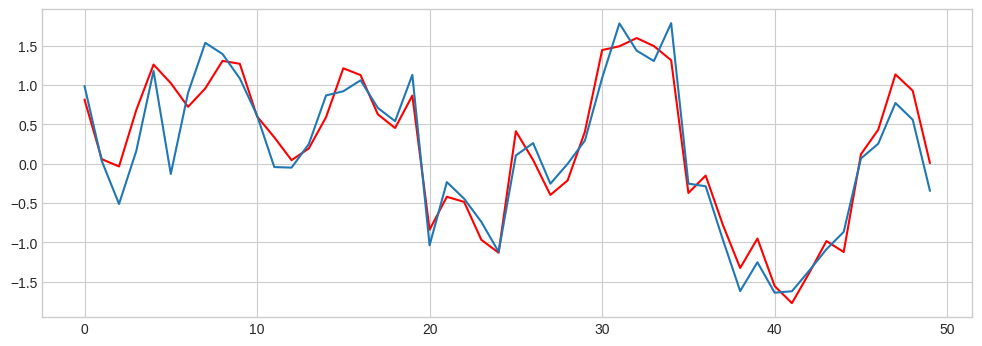

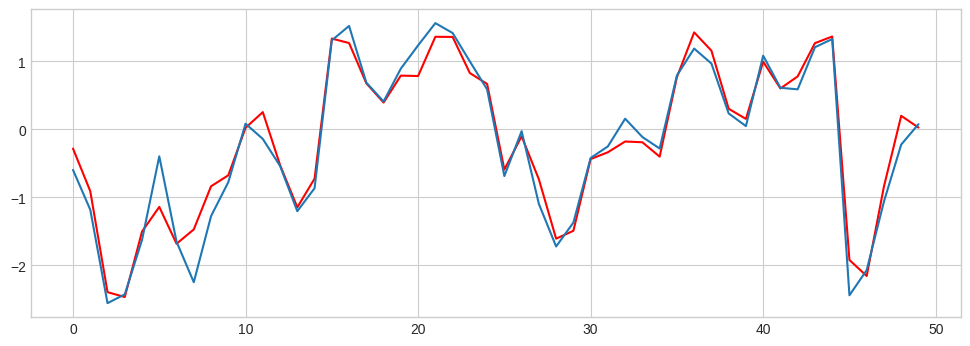

In [23]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

#Inject anomaly

In [20]:
x, y = next(iter(test_iter))

In [24]:
batch = 5
x_a = x.clone()
change_value = [0, 1,2]
injected = []
for i in range(x.shape[2]):
    print(i)
    if i in change_value:
        print('changing')
        inject = list(x_a[batch ,:, i].cpu().numpy())
        inject_anomaly = [t + 10*np.std(inject)*random.uniform(0.8,1) for t in inject]
        #x_a[batch,:, i] =  torch.Tensor(fake)
        x_a[batch,:, i] = torch.Tensor(inject_anomaly)
        
        injected.append(i)
    
    if all(x_a[batch,:,i]==x[batch,:,i]):
        print('original tensor and anomalous are the same on features',i)

0
changing
1
changing
2
changing
3
original tensor and anomalous are the same on features 3


In [26]:
idx = batch*sequence_length
x_a, enc, yo_a = model(x_a.to('cuda'))
x, enc, yo = model(x.to('cuda'))
len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

40

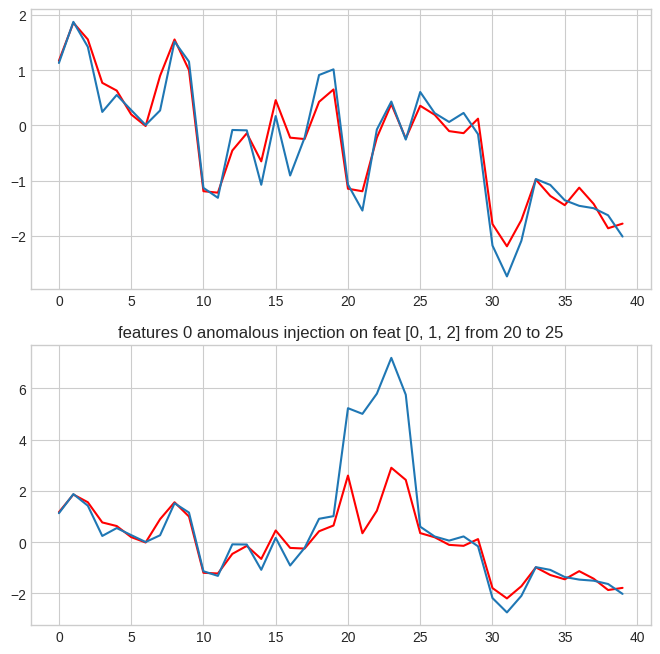

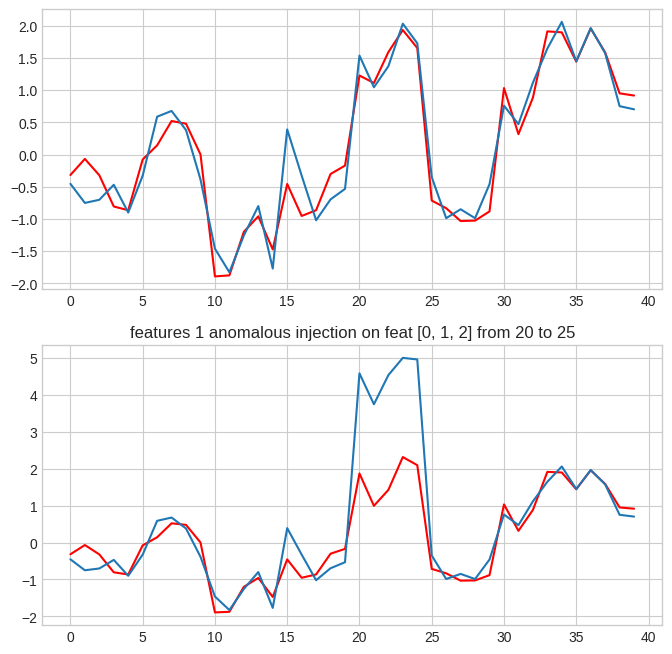

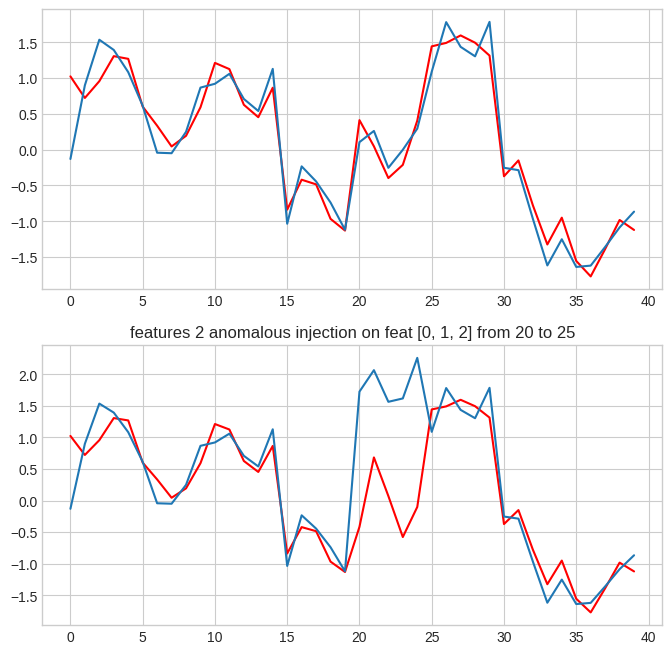

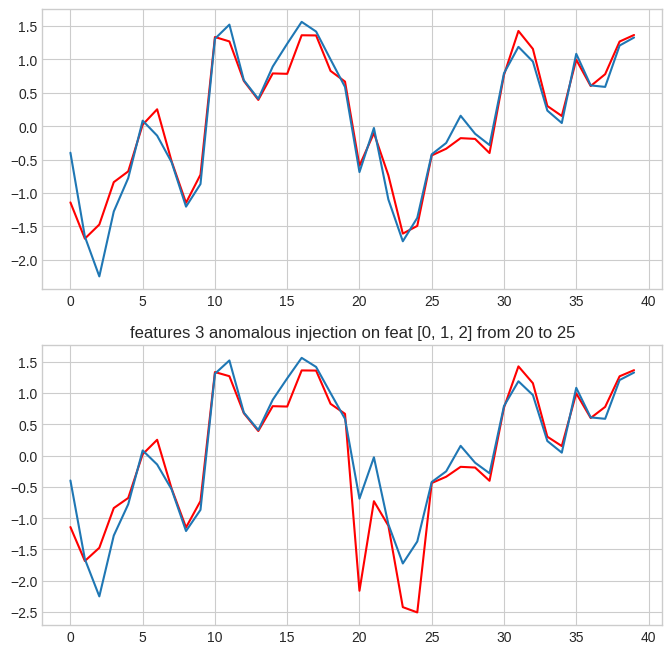

In [30]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig, axs = plt.subplots(2, figsize=(8,8))
    #x = np.linspace(0, sequence_length)
    axs[0].plot(yo.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[0].plot(x.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())
    plt.title('no anomalies')
    axs[1].plot(yo_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[1].plot(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

    an_idx = len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())//2

    plt.title('features {} anomalous injection on feat {} from {} to {}'\
              .format(i ,injected, int(an_idx), int(an_idx)+ batch))